RPCA из первой домашки по матвычислам:

In [1]:
# %load robust-pca/r_pca.py
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


In [102]:
test_arr = np.random.rand(100, 100)
test_rpca = R_pca(test_arr)
test_l, test_r = test_rpca.fit(max_iter=4000, iter_print=500)

iteration: 1, error: 0.1748107183530333
iteration: 500, error: 0.00024886999944231724
iteration: 1000, error: 7.519550426081771e-05
iteration: 1500, error: 7.80732302594476e-06
iteration: 1656, error: 5.71102863403782e-06


In [106]:
sigmas = np.linalg.svd(test_l, compute_uv = False)
print(sigmas.sum())
print((sigmas > 1e-14).sum())
print((sigmas > 0).sum())

161.81014149989701
57
100


In [108]:
print((np.abs(test_r) > 1e-14).sum())
print((np.abs(test_r) > 0).sum())

5580
5580


In [109]:
print(np.linalg.norm(test_l + test_r - test_arr))

5.71102863403782e-06


Мой код:

In [37]:
def values(func, left, right, n):
    return func(np.linspace(left, right, n))

def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def iwtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

Попробуем внедрить RPCA явно в качестве замены для SVD.

In [110]:
def wtt_rpca(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        
        #делаем разложение A = L + S, L --- малоранговая, S --- разреженная
        #затем: L = U Sigma V^T --- SVD для L. Ненулевых сингулярных чисел будет мало (надеемся)
        #U^T A = Sigma V^T + U^T S. Старшие строки оставляем для дальнейшей работы.
        #Надеемся, что младшие строки U^T S тоже будут разреженными...
        
        rpca = R_pca(A) 
        L, S = rpca.fit(
            max_iter=4000,
            iter_print=1000
        )
        
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            #A = (u.T @ A)[:r_cur,:]
            A = (u.T @ (L + S))[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

In [111]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

modes = [2] * d
ranks = [4] * (d - 1)

filters, ranks = wtt_filter(
    sin_sq_values,
    d,
    modes,
    ranks=ranks,
    eps=0,
    check_correctness=True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)
print(ranks)

[2, 4, 4, 4, 4, 4, 4, 4, 2]


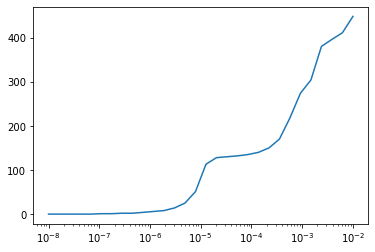

In [112]:
thresholds = np.logspace(-8, -2, 30)
nnzs = [(np.abs(wtt_res) < t).sum() for t in thresholds]

plt.plot(thresholds, nnzs)
plt.xscale('log')
plt.show()

По горизонтали --- $\delta$, по вертикали --- количество элементов, которые по модулю меньше $\delta$.

Попробуем теперь обучить rpca-фильтры.

In [113]:
ranks_est = [4] * (d - 1)
filters_rpca, ranks_rpca = wtt_rpca(
    sin_sq_values,
    d,
    modes,
    ranks=ranks_est,
    eps=0,
    check_correctness=True
)
wtt_res_rpca = wtt_apply(
    sqrt_x_values,
    d,
    filters_rpca,
    modes,
    ranks_rpca,
    True
)
print(ranks_rpca)

iteration: 1, error: 0.008912992614624719
iteration: 2, error: 1.6590207967226576e-06
iteration: 1, error: 0.017529606220128675
iteration: 1000, error: 9.83414997343143e-05
iteration: 1468, error: 1.4786521844232237e-06
iteration: 1, error: 0.03776271978490709
iteration: 1000, error: 4.137265921142181e-05
iteration: 2000, error: 1.1517317796141675e-05
iteration: 3000, error: 6.7848631123908626e-06
iteration: 4000, error: 5.045218463395819e-06
iteration: 1, error: 0.15715025349064352
iteration: 1000, error: 0.00038623886602603665
iteration: 2000, error: 6.708841040145559e-06
iteration: 2439, error: 2.2062405841059837e-06
iteration: 1, error: 0.342485973351192
iteration: 1000, error: 3.3955045513934303e-06
iteration: 1098, error: 1.8553151349272024e-06
iteration: 1, error: 0.8750440548651606
iteration: 620, error: 1.450953213201784e-06
iteration: 1, error: 1.7737965441125703
iteration: 607, error: 1.137066196113527e-06
iteration: 1, error: 2.300479751795083
iteration: 138, error: 9.56954

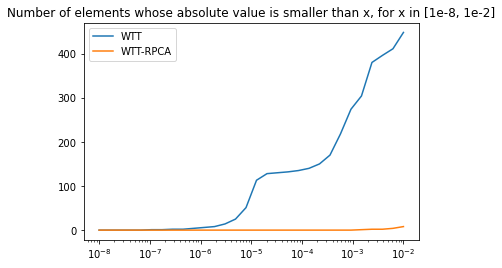

In [114]:
nnzs_rpca = [(np.abs(wtt_res_rpca) < t).sum() for t in thresholds]

plt.plot(thresholds, nnzs, label='WTT')
plt.plot(thresholds, nnzs_rpca, label='WTT-RPCA')
plt.title("Number of elements whose absolute value is smaller than x, for x in [1e-8, 1e-2]")
plt.xscale('log')
plt.legend()
plt.show()

Как будто с RPCA хуже...
Давайте ещё такой график отрисуем, для наглядности.

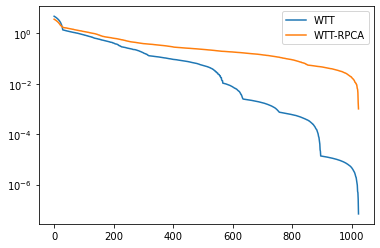

In [115]:
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res))), label='WTT')
plt.plot(np.arange(wtt_res_rpca.size), np.flip(np.sort(np.abs(wtt_res_rpca))), label='WTT-RPCA')
plt.yscale('log')
plt.legend()
plt.show()

Действительно, коэффициенты оказались больше.

Но мы попробуем дать больше рангов.

In [116]:
ranks_est = [30] * (d - 1)

filters, ranks = wtt_filter(
    sin_sq_values,
    d,
    modes,
    ranks=ranks_est,
    eps=0,
    check_correctness=True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)
print(ranks)

[2, 4, 8, 16, 30, 16, 8, 4, 2]


In [117]:
thresholds = np.logspace(-8, -2, 30)
nnzs = [(np.abs(wtt_res) < t).sum() for t in thresholds]

In [118]:
filters_rpca, ranks_rpca = wtt_rpca(
    sin_sq_values,
    d,
    modes,
    ranks=ranks_est,
    eps=0,
    check_correctness=True
)
wtt_res_rpca = wtt_apply(
    sqrt_x_values,
    d,
    filters_rpca,
    modes,
    ranks_rpca,
    True
)
print(ranks_rpca)

iteration: 1, error: 0.008912992614624719
iteration: 2, error: 1.6590207967226576e-06
iteration: 1, error: 0.017529606220128675
iteration: 1000, error: 9.83414997343143e-05
iteration: 1468, error: 1.4786521844232237e-06
iteration: 1, error: 0.03776271978490709
iteration: 1000, error: 4.137265921142181e-05
iteration: 2000, error: 1.1517317796141675e-05
iteration: 3000, error: 6.7848631123908626e-06
iteration: 4000, error: 5.045218463395819e-06
iteration: 1, error: 0.10677025182489742
iteration: 1000, error: 0.00012493513453890227
iteration: 2000, error: 2.7400955399934854e-05
iteration: 3000, error: 8.113814705117473e-06
iteration: 3882, error: 2.236703163219992e-06
iteration: 1, error: 0.2193854591997378
iteration: 1000, error: 5.157087866652506e-05
iteration: 1821, error: 2.232526902397851e-06
iteration: 1, error: 0.2769410367348508
iteration: 548, error: 2.1957448816157934e-06
iteration: 1, error: 0.8559523734712209
iteration: 412, error: 1.5965286042548052e-06
iteration: 1, error: 1

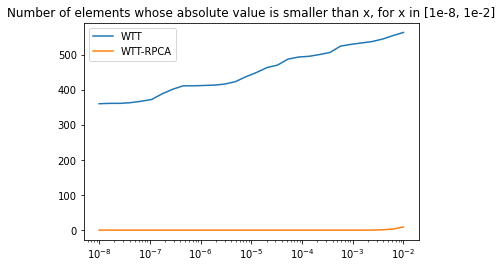

In [119]:
nnzs_rpca = [(np.abs(wtt_res_rpca) < t).sum() for t in thresholds]

plt.plot(thresholds, nnzs, label='WTT')
plt.plot(thresholds, nnzs_rpca, label='WTT-RPCA')
plt.title("Number of elements whose absolute value is smaller than x, for x in [1e-8, 1e-2]")
plt.xscale('log')
plt.legend()
plt.show()

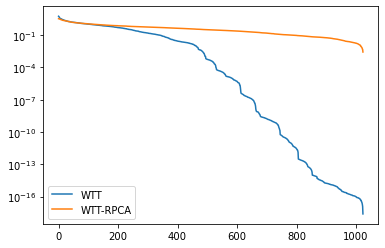

In [120]:
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res))), label='WTT')
plt.plot(np.arange(wtt_res_rpca.size), np.flip(np.sort(np.abs(wtt_res_rpca))), label='WTT-RPCA')
plt.yscale('log')
plt.legend()
plt.show()

In [121]:
iwtt_result = iwtt_apply(
    wtt_res,
    d,
    filters,
    modes,
    ranks,
    True
)
iwtt_result_rpca = iwtt_apply(
    wtt_res_rpca,
    d,
    filters_rpca,
    modes,
    ranks_rpca,
    True
)

In [122]:
print(np.linalg.norm(sqrt_x_values - iwtt_result))
print(np.linalg.norm(sqrt_x_values - iwtt_result_rpca))

6.483229259128888e-14
3.482596148816006e-14


Почему-то в текущем режиме RPCA не может у образующихся матриц найти разложение, у которого малоранговая компонента была бы действительно малоранговой.